#As a first step
We start by Loging on *AICrowd's* platform

In [ ]:
!pip install --upgrade fastai git+https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git >/dev/null
%load_ext aicrowd.magic
API_KEY = 'ea1eae9d9cd75c3ad9c179d3dc91ece3'
%aicrowd login --api-key $API_KEY

  Running command git clone -q https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli.git /tmp/pip-req-build-lq5ek3cs
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
API Key valid
Saved API Key successfully!


#As a second step
We import our needed packages.

In [ ]:
#Import packages
import pandas as pd
from fastai.vision.all import *
from fastai.data.core import *
import os
import torch
from torch import nn
from torchvision.models import resnet50
from bottleneck_transformer_pytorch import BottleStack

#As a third step
We convert the downloaded AIcrowd dataset into Google Colab.

In [ ]:
!aicrowd dataset download --challenge rover-classification -j 3

sample_submission.csv:   0% 0.00/164k [00:00<?, ?B/s]
test.zip:   0% 0.00/66.5M [00:00<?, ?B/s]

train.csv:   0% 0.00/689k [00:00<?, ?B/s]

                                         
sample_submission.csv: 100% 164k/164k [00:00<00:00, 1.73MB/s]

train.csv: 100% 689k/689k [00:00<00:00, 4.45MB/s]

train.zip:   0% 0.00/266M [00:00<?, ?B/s]

val.csv: 100% 65.0k/65.0k [00:00<00:00, 1.48MB/s]
test.zip:  50% 33.6M/66.5M [00:00<00:00, 59.4MB/s]
train.zip:  13% 33.6M/266M [00:00<00:03, 62.7MB/s]

test.zip: 100% 66.5M/66.5M [00:00<00:00, 64.2MB/s]


test.zip: 100% 66.5M/66.5M [00:00<00:00, 67.8MB/s]
train.zip:  38% 101M/266M [00:01<00:02, 71.9MB/s] 
val.zip: 100% 26.5M/26.5M [00:00<00:00, 32.8MB/s]
train.zip: 100% 266M/266M [00:03<00:00, 83.2MB/s]


#Then
We setup our data after downloading it.

In [ ]:
!rm -rf data
!mkdir data

!unzip train.zip  -d data/train
!unzip val.zip -d data/val
!unzip test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: data/test/5499.jpg      
  inflating: data/test/55.jpg        
  inflating: data/test/550.jpg       
  inflating: data/test/5500.jpg      
  inflating: data/test/5501.jpg      
  inflating: data/test/5502.jpg      
  inflating: data/test/5503.jpg      
  inflating: data/test/5504.jpg      
  inflating: data/test/5505.jpg      
  inflating: data/test/5506.jpg      
  inflating: data/test/5507.jpg      
  inflating: data/test/5508.jpg      
  inflating: data/test/5509.jpg      
  inflating: data/test/551.jpg       
  inflating: data/test/5510.jpg      
  inflating: data/test/5511.jpg      
  inflating: data/test/5512.jpg      
  inflating: data/test/5513.jpg      
  inflating: data/test/5514.jpg      
  inflating: data/test/5515.jpg      
  inflating: data/test/5516.jpg      
  inflating: data/test/5517.jpg      
  inflating: data/test/5518.jpg      
  inflating: data/test/5519.jpg      
  inflating: data/test/552.jpg       

#After that
We read the CSV file from the data generated.


In [ ]:
train_df = pd.read_csv("data/train.csv")
train_df['ImageID'] = train_df['ImageID'].astype(str)+".jpg"
train_df

ImageID         label
0          0.jpg     curiosity
1          1.jpg     curiosity
2          2.jpg     curiosity
3          3.jpg  perseverance
4          4.jpg     curiosity
...          ...           ...
39995  39995.jpg  perseverance
39996  39996.jpg     curiosity
39997  39997.jpg     curiosity
39998  39998.jpg     curiosity
39999  39999.jpg     curiosity

[40000 rows x 2 columns]

#The next step
We should classify our labels which are:
1.   Curiosity
2.   Perseverance

In [ ]:
train_df['label'].unique()

array(['curiosity', 'perseverance'], dtype=object)

#Next
We download the limiting transformer package

In [ ]:
!pip install bottleneck-transformer-pytorch

#Later
We set the path of train's folder

In [ ]:
path = "/content/data/train"

def get_x(train_df):
    return path + "/" + train_df['ImageID'] #ImageID

def get_y(train_df):
    return train_df['label'] #Label

In [ ]:
def getblock(size=256,batch=8, data_df=train_df):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      splitter=RandomSplitter(seed=42),
                      get_x=get_x, # Using the function above.
                      get_y=get_y, # Using the function above.
                      item_tfms = Resize(256), # Resizing images to 400 pixels.
                      
                      # Data Augmentation time:
                      batch_tfms = [*aug_transforms(mult=1.0, do_flip=False,
                                                   flip_vert=False, max_rotate=0,
                                                   min_zoom=1.0, max_zoom=1.0,
                                                   pad_mode="zeros",
                                                   xtra_tfms=None,max_warp=0,
                                                   p_affine=0, p_lighting=0),
                                    Normalize.from_stats(*imagenet_stats)])
    
    return block.dataloaders(data_df, bs=batch)

#Then
We return the data

In [ ]:
dataloader = getblock()

#After that
We plot the pictures

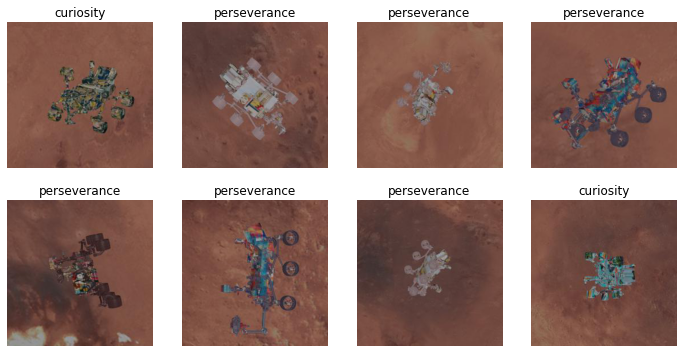

In [ ]:
dataloader.show_batch()

#The next step
1.  We specify the image resolutions
2.  We call for the original model
1.  We make the surgey of the model






In [ ]:
layer = BottleStack(
    dim = 256,
    fmap_size = 64,        # set specifically for imagenet's 224 x 224
    dim_out = 2048,
    proj_factor = 4,
    downsample = True,
    heads = 4,
    dim_head = 128,
    rel_pos_emb = True,
    activation = nn.ReLU()
)
#Original model
resnet = resnet50()

# model surgery

backbone = list(resnet.children())

model = nn.Sequential(
    *backbone[:5],
    layer,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(1),
    nn.Linear(2048, 1000)
)

#Next
We define the final model

In [ ]:
learn = Learner(dataloader, model, metrics = accuracy)

#Later
We gather all the data about the model and we make a summary based on all the elements

In [ ]:
learn.summary()

Sequential (Input shape: 3)
Layer (type)         Output Shape         Param #    Trainable 
                     3 x 64 x 160 x 160  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     3 x 256 x 80 x 80   
Conv2d                                    16384      True      
BatchNorm2d                               512        True      
ReLU                                                           
___________________________________________

#Then
We have our learning rate graph

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0005754399462603033)

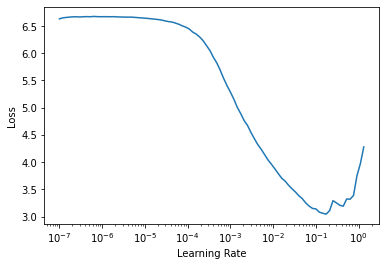

In [ ]:
learn.lr_find()

#After that
We start our training

In [ ]:
learn.fine_tune(3, 0.0005754399462603033)

#The next step
1.   We determin the test data
2.   Convert categorical values into label names 



In [ ]:
#Define Test data
test_imgs_name = get_image_files(os.path.join("/content/data", "test"))
test_dls = dataloader.test_dl(test_imgs_name)

# Convert categorical values into label names
class_to_label_mapping = {v: k for v, k in enumerate(dataloader.vocab)}
print(class_to_label_mapping)

test_img_ids = [re.sub(r"\D", "", str(img_name)) for img_name in test_imgs_name]

{0: 'curiosity', 1: 'perseverance'}


#Later

In [ ]:
#Predict based on the test data
_,_,results = learn.get_preds(dl = test_dls, with_decoded = True)

results = [class_to_label_mapping[i] for i in results.numpy()]

#Then
We create a submission file where we will find the imageid and the label

In [ ]:
submission = pd.DataFrame({"ImageID":test_img_ids, "label":results})
submission
submission.to_csv("submission.csv", index=False)

ImageID         label
0       5266     curiosity
1       2729  perseverance
2       7586     curiosity
3       4675     curiosity
4       9178  perseverance
...      ...           ...
9995    1623  perseverance
9996    1315     curiosity
9997    6868  perseverance
9998    1941  perseverance
9999    7418     curiosity

[10000 rows x 2 columns]

#Final step
We submit our work.

In [ ]:
#Submit 
!aicrowd submission create -c rover-classification -f submission.csv

submission.csv ━━━━━━━━━━━━━━━━━━ 100.0% • 165.3/163.7 KB • 528.5 kB/s • 0:00:00
                                                   ╭─────────────────────────╮                                                    
                                                   │ Successfully submitted! │                                                    
                                                   ╰─────────────────────────╯                                                    
                                                         Important links                                                          
┌──────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-7/problems/rover-classification/submissions/126848              │
│                  │                                                                                                             │
│ 